In [1]:
import random
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import copy
import math
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from common.optim.meta import MetaData
from common.optim.optimise_weights import NetLineStepProcessor
from common.util import AverageMeter, loss_crossentropy_np
from common.cnn import make_resnet18v2

from torchvision.datasets import CIFAR100
from torchvision import transforms

import logging

In [ ]:
logging.basicConfig(filename="logs/cifar100_restnet18_wieighted_alpha.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s")


#### Constants

In [ ]:
BATCH_SIZE = 128
SAMPLE_SIZE = 1024
OUTPUT_DIM = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EXPERIMENTS = 1 #10
EPOCHS_PER_EXPERIMENT = 50
DATASET_PATH = "./datasets"

#### CIFAR100 dataset

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

train_dataset = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_dataset = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

In [5]:
sample_ids = random.sample(range(0, len(train_dataset)), SAMPLE_SIZE)
trainset_sample = Subset(train_dataset, sample_ids)
sample_dataloader = DataLoader(trainset_sample, batch_size=SAMPLE_SIZE)
sample_batch = list(sample_dataloader)[0]
sample_images, sample_labels = sample_batch
sample_images = sample_images.to(DEVICE)
sample_labels = sample_labels.to(DEVICE)

##### UTILS

In [6]:
def calculate_accuracy(prediction, target):
    return np.average((prediction ==target).detach().cpu())

def test_loop(testNet):
    accuracy_meter, loss_meter  = AverageMeter(), AverageMeter()
    testNet.train(False)
    with torch.no_grad():
        for test_batch in test_dataloader:
            images, labels = test_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                logits = testNet.forward(images).detach().cpu()

                prediction = logits.argmax(dim=-1).to(DEVICE)
                loss = loss_crossentropy_np(np.transpose(logits.numpy()), labels)
                loss_meter.update(loss)
                accuracy_meter.update(calculate_accuracy(prediction, labels))

    return accuracy_meter.avg, loss_meter.avg

#### Compare optimisers

In [7]:
def experiment_comparison(data, var, low, high, title="Comparison"):

    MEAN_ADAM = data[low:high,0]
    MEAN_NETLINE = data[low:high,1]
    MEAN_SGD = data[low:high,2]
    if (var is not None):
        low, up = data[low:high]-var[low:high], data[low:high]+var[low:high]
        LOW_ADAM, UP_ADAM = low[:,0], up[:,0]
        LOW_NETLINE, UP_NETLINE = low[:,1], up[:,1]
        LOW_SGD, UP_SGD = low[:,2], up[:,2]
        cord_x = np.arange(0, len(MEAN_ADAM[:,1]))

    #display.clear_output()
    fig, axes = plt.subplots(5, 2, figsize=(18, 30))
    axes[0,0].set_title('Loss (average cross entropy)')
    axes[0,0].plot(MEAN_ADAM[:,1], color='g',alpha=.5, label='Adam')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_ADAM[:,1], y2=UP_ADAM[:,1], color='g', alpha=.125)
    axes[0,0].plot(MEAN_NETLINE[:,1], color='b',alpha=.5, label='Net-line')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_NETLINE[:,1], y2=UP_NETLINE[:,1], color='b', alpha=.125)
    axes[0,0].plot(MEAN_SGD[:,1], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0,0].fill_between(x=cord_x, y1=LOW_SGD[:,1], y2=UP_SGD[:,1], color='grey', alpha=.125)
    axes[0,0].grid()
    axes[0,0].legend()
    axes[0,0].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,0].set_ylabel("Loss value")

    axes[0,1].set_title('Accuracy (top 1)')
    axes[0,1].plot(MEAN_ADAM[:,0], color='g', alpha=.5, label='Adam')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_ADAM[:,0], y2=UP_ADAM[:,0], color='g', alpha=.125)
    axes[0,1].plot(MEAN_NETLINE[:,0], color='b', alpha=.5, label='Net-line')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_NETLINE[:,0], y2=UP_NETLINE[:,0], color='b', alpha=.125)
    axes[0,1].plot(MEAN_SGD[:,0], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0,1].fill_between(x=cord_x, y1=LOW_SGD[:,0], y2=UP_SGD[:,0], color='grey', alpha=.125)
    axes[0,1].grid()
    axes[0,1].legend()
    axes[0,1].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,1].set_ylabel("Accuracy value")
    axes[1,0].set_title('PQ vector norm')
    axes[1,0].plot(MEAN_NETLINE[:,4], color='grey',alpha=.5, label='PQ vector norm average per epoch')
    axes[1,1].set_title('QQ vector norm')
    axes[1,1].set_yscale("log")
    axes[1,1].plot(MEAN_NETLINE[:,3], color='green',alpha=.5, label='QQ1 vector norm average per epoch')
    axes[2,0].set_title('Cos phi and kappa average')
    axes[2,0].plot(MEAN_NETLINE[:,5], color='green',alpha=.5, label='Cos phi average per epoch')
    axes[2,0].plot(MEAN_NETLINE[:,9], color='blue',alpha=.5, label='Kappa average per epoch')
    axes[2,0].grid()
    axes[2,0].legend()
    axes[2,1].set_title('Eta calculated')
    axes[2,1].set_yscale("log")
    axes[2,1].plot(MEAN_NETLINE[:,6], color='green',alpha=.5, label='Eta average per epoch')
    axes[2,1].plot(MEAN_SGD[:,6], color='red',alpha=.5, label='Eta SGD average per epoch')
    axes[2,1].grid()
    axes[2,1].legend()
    axes[3,0].set_title('Sample ratio')
    axes[3,0].plot(MEAN_NETLINE[:,16], color='green',alpha=.5, label='Sample ratio')
    axes[3,0].grid()
    axes[3,0].legend()
    axes[3,1].set_title('Sample cos')
    axes[3,1].plot(MEAN_NETLINE[:,15], color='green',alpha=.5, label='Sample cos')
    axes[3,1].set_yscale("log")
    axes[3,1].grid()
    axes[3,1].legend()

    axes[4,0].set_title('Armiho coeff')
    axes[4,0].plot(MEAN_NETLINE[:,8], color='green',alpha=.5, label='Armiho coeff per epoch')
    axes[4,0].legend()
    axes[4,1].set_title('Grad norm2')
    axes[4,1].plot(MEAN_NETLINE[:,11], color='grey',alpha=.5, label='Grad norm2 squared')
    axes[4,1].set_yscale("log")
    dummy=fig.suptitle(title)

    plt.show()

def timing_comparison(data, low, high, title="Comparison"):
    TIMING_ADAM = data[low:high,0]
    TIMING_NETLINE = data[low:high,1]
    TIMING_SGD = data[low:high,2]

    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.set_title(title)
    axes.plot(TIMING_ADAM[:,2], color='g',alpha=.5, label='Adam')
    axes.plot(TIMING_NETLINE[:,2], color='b',alpha=.5, label='Net-line')
    axes.plot(TIMING_SGD[:,2], color='grey', alpha=.5, label='SGD')
    axes.grid()
    axes.legend()
    axes.set_xlabel("Epoch (series of gradient descent steps)")
    axes.set_ylabel("Time ns")
    plt.show()

def rf(value):
    return f"{value:.5f}"

def accuracy_comparison(exp_results, low, high, title="Validation accuracy"):
    adam_mean, adam_var = np.mean(exp_results[:, low:high, 0, 0], axis=0), np.var(exp_results[:, low:high, 0, 0], axis=0)
    nline_mean, nline_var = np.mean(exp_results[:, low:high, 1, 0], axis=0), np.var(exp_results[:, low:high, 1, 0], axis=0)
    sgd_mean, sgd_var = np.mean(exp_results[:, low:high, 2, 0], axis=0), np.var(exp_results[:, low:high, 2, 0], axis=0)

    p1, p2, p3, p4, p5 = min(10,EPOCHS_PER_EXPERIMENT), min(20,EPOCHS_PER_EXPERIMENT), min(30,EPOCHS_PER_EXPERIMENT)\
        , min(50,EPOCHS_PER_EXPERIMENT), min(75,EPOCHS_PER_EXPERIMENT)

    report = np.zeros((3,5), dtype='U256')
    for row in range(3):
        mean, var = (adam_mean, adam_var) if row == 0 else (nline_mean, nline_var) if row == 1 else (sgd_mean, sgd_var)
        for col in range(5):
            indx = p1-1 if col == 0 else p2-1 if col == 1 else p3-1 if col == 2 else p4-1 if col == 3 else p5-1
            report[row, col] = rf(mean[indx]) + "+/-" + rf(var[indx])

    fig, ax = plt.subplots(figsize=(8, 8))
    # hide axes
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    tab_plot = ax.table(cellText=report, colLabels=[str(p1)+' epochs',str(p2)+' epochs',str(p3)+' epochs',str(p4)+' epochs',str(p5)+' epochs']\
        , rowLabels=['Adam','Net-line','SGD'], cellLoc='left', loc='center')
    tab_plot.auto_set_font_size(False)
    tab_plot.set_fontsize(11)
    tab_plot.scale(3, 5)
    #fig.tight_layout()
    ax.set_title(title)
    plt.show()


In [ ]:
def cosine_annealing_lr(eta0, eta1, epoch_cos_start, epoch_finish, epoch_curr):
    if epoch_curr < epoch_cos_start:
        return eta0
    return eta1 + 0.5*(eta0-eta1)*(1+math.cos((epoch_curr-epoch_cos_start)*math.pi/(epoch_finish-epoch_cos_start)))

def cosine_annealing2_lr(eta0, eta1, epoch_cos_start, epoch_cos_finish, epoch_curr):
    if epoch_curr < epoch_cos_start:
        return eta0
    if epoch_cos_finish <= epoch_curr:
        return eta1
    return eta1 + 0.5*(eta0-eta1)*(1+math.cos((epoch_curr-epoch_cos_start)*math.pi/(epoch_cos_finish-epoch_cos_start)))

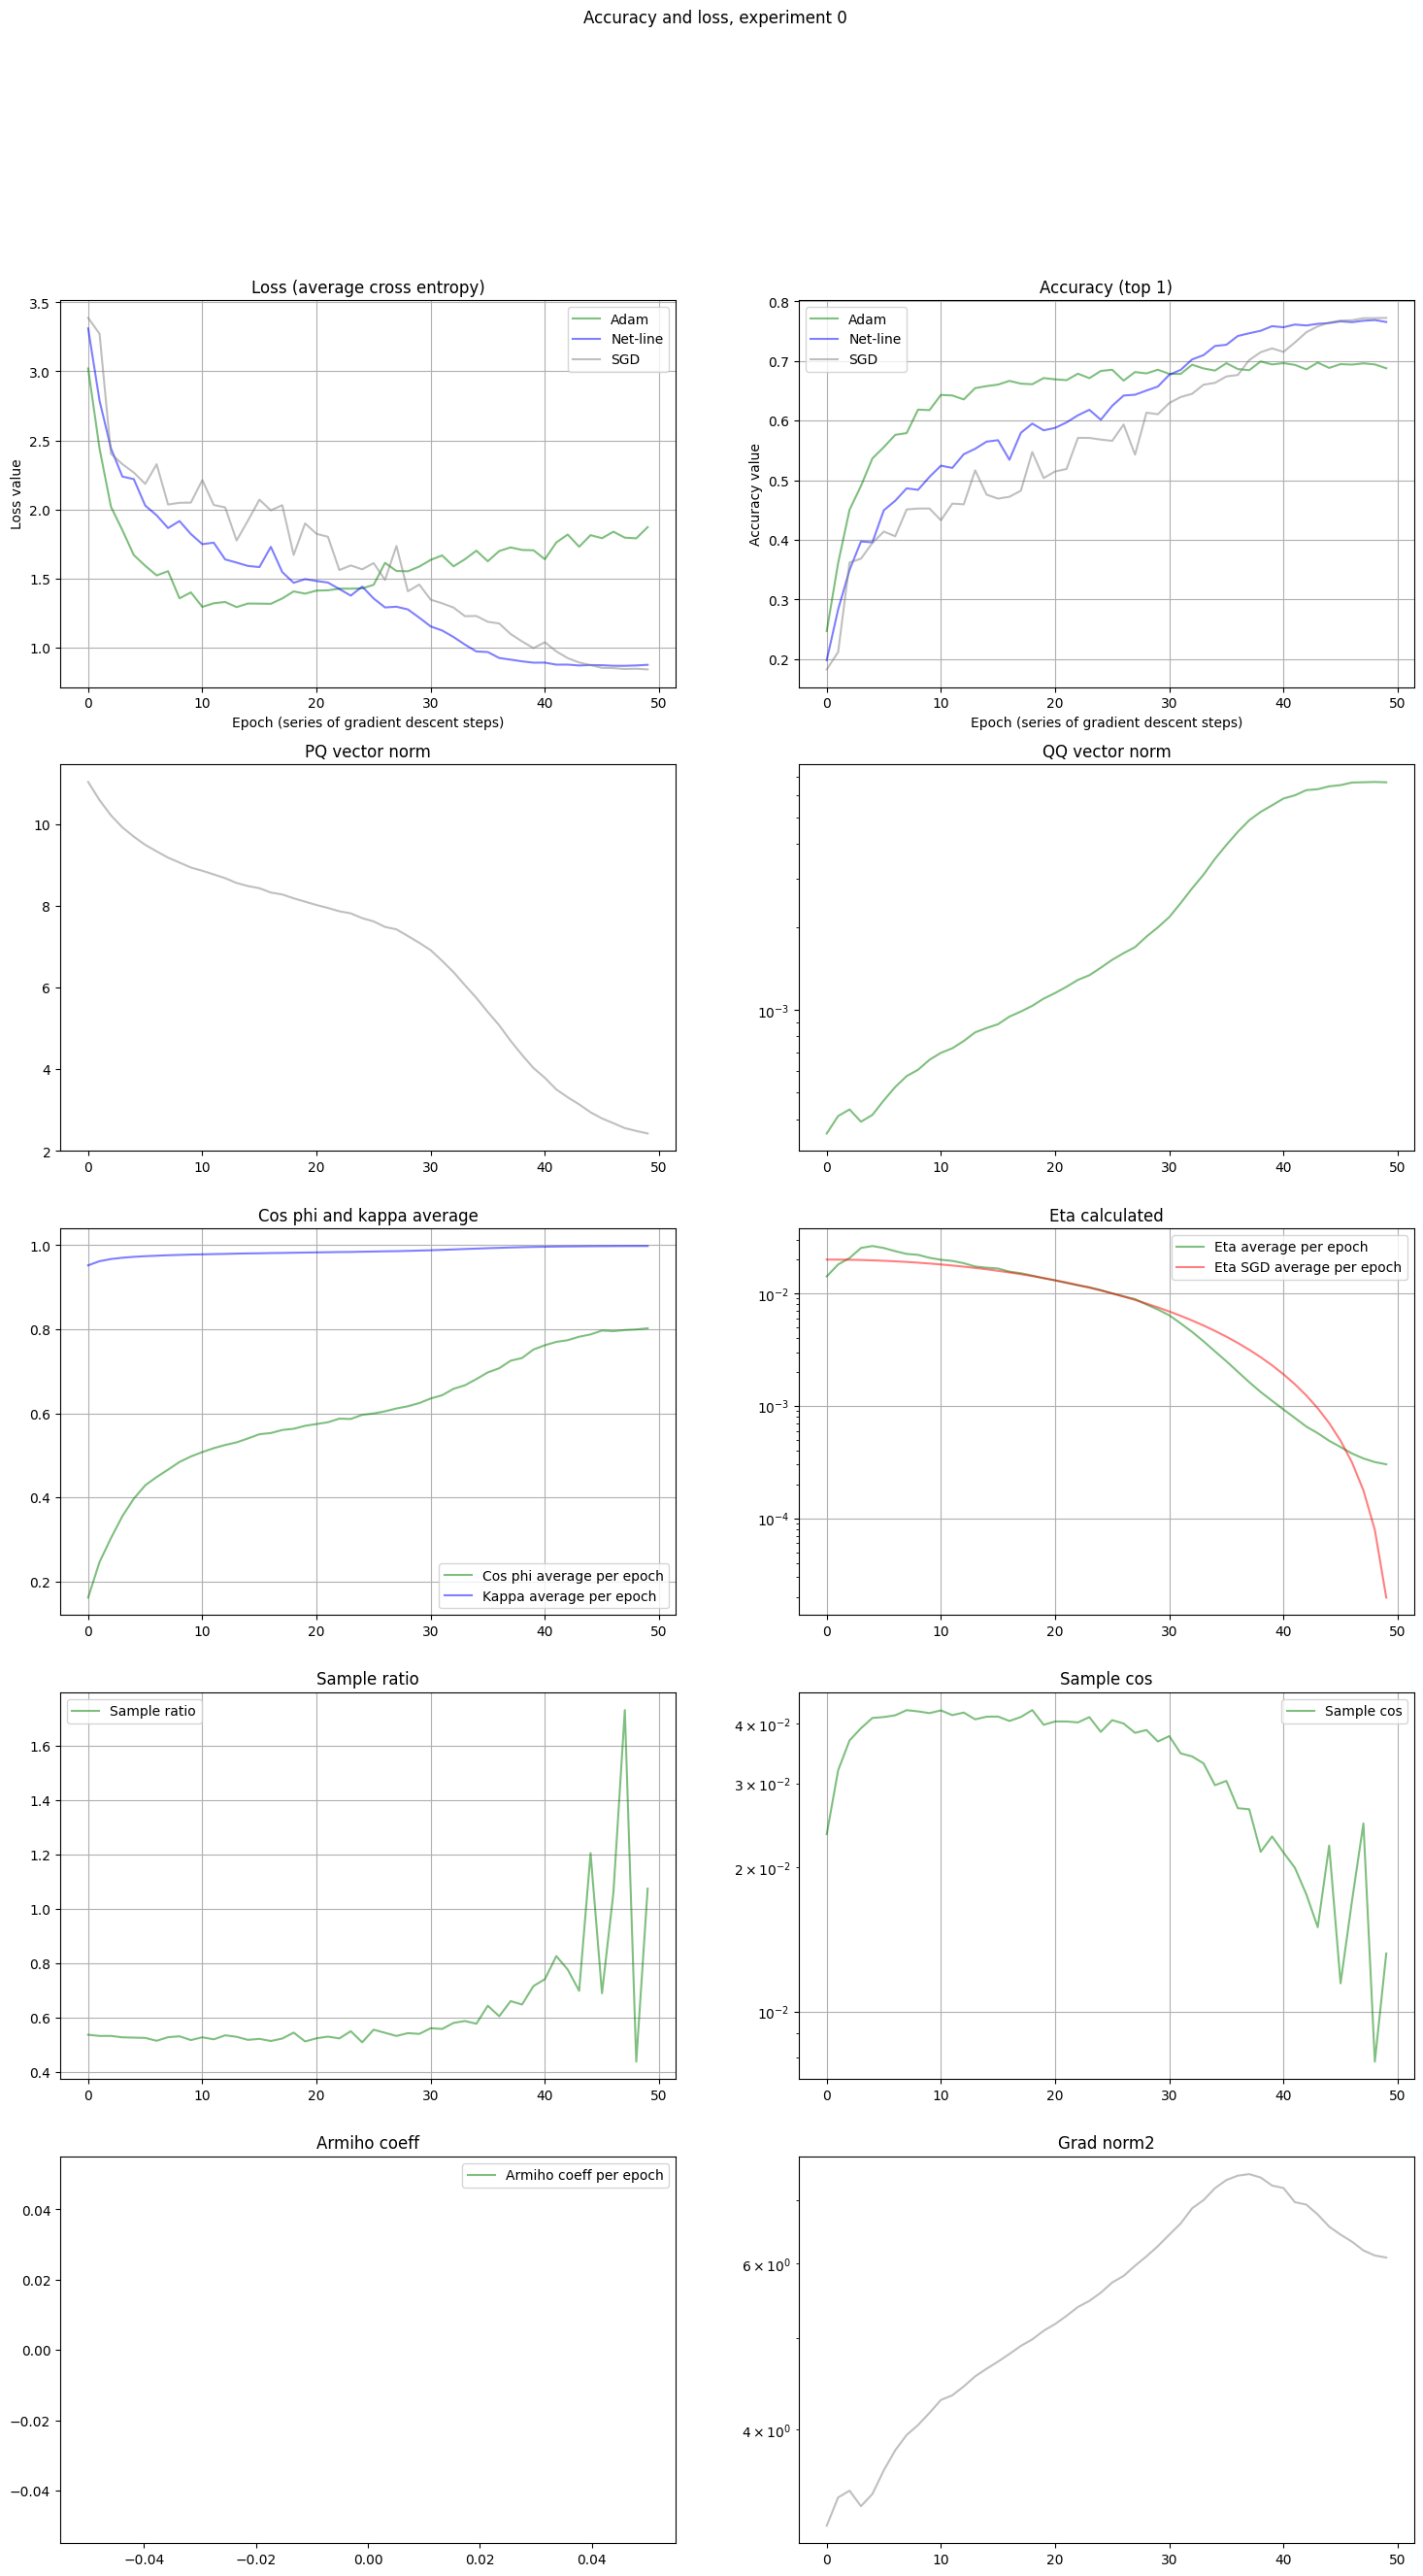

Experiment=0, sgd=0.7724485759493671, net-line=0.7655261075949367, adam=0.6878955696202531, alpha=0.10098566233569028, beta=0.0001, weight_decay=0.005


In [ ]:
meta = MetaData(batch_size = BATCH_SIZE, output_dim=OUTPUT_DIM, device=DEVICE)

'''
0-num of experiment; 1-epoch;
2-net: 0-Adam, 1-Net-line 2step, 2-SGD
3-param: 0-test accuracy (Top-1), 1-test errror (cross-entropy), 2-time per step, 3 - qq_norm_test,
4 - pq_norm, 5 - cos_phi, 6 - eta_calculated, 7 - alpha/lr(sgd), 8 - armiho_coeff, 9 - kappa avg, 10 - empty,
11 - grad_norm2_sq, 12 - empty, 13 - empty, 14 - empty, 15 - cos_sample, 16 - ratio_sample
'''
experimental_results = np.zeros((EXPERIMENTS, EPOCHS_PER_EXPERIMENT, 3, 17))
eta_fixed = 0.01

for experiment in range(EXPERIMENTS):

    #Adam
    net_adam = make_resnet18v2(3, OUTPUT_DIM).to(DEVICE)
    loss_adam = nn.CrossEntropyLoss()
    opt_adam = optim.Adam(net_adam.parameters(), lr=0.001)

    #Net-line 2step
    net_linestep = copy.deepcopy(net_adam)
    opt_linestep = NetLineStepProcessor(net_linestep, meta, DEVICE)
    opt_linestep.eta1 = 0.00001
    opt_linestep.alpha = 0.4
    opt_linestep.beta = 0.0001
    opt_linestep.dropout_mode=False
    opt_linestep.do_logging=False
    opt_linestep.do_calc_armiho = False

    #Sgd scheduled lr
    net_sgd = copy.deepcopy(net_adam)
    loss_sgd = nn.CrossEntropyLoss()
    #opt_sgd = optim.SGD(net_sgd.parameters(), lr=1e-2, momentum=0.9, nesterov=True)
    opt_sgd = optim.SGD(net_sgd.parameters(), 0.02, momentum=0.9, weight_decay=5e-3)
    schd_sgd = optim.lr_scheduler.CosineAnnealingLR(opt_sgd, T_max=EPOCHS_PER_EXPERIMENT)

    for epoch in range(EPOCHS_PER_EXPERIMENT):
        #alpha, beta for net-line
        opt_linestep.alpha = cosine_annealing2_lr(0.35, 0.1, 25, 50, epoch)
        opt_linestep.beta = 0.0001
        weight_decay0 = 5e-3
        opt_linestep.kappa_step_pp = 0.0125

        mt_kappa, mt_cos_sample, mt_ratio_sample, mt_adam, mt_netline, mt_sgd, mt_qq, mt_pq, mt_cos, mt_eta, mt_armiho, mt_grad = \
            AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
        net_adam.train(True)
        net_linestep.train(True)
        net_sgd.train(True)

        for train_batch in train_dataloader:
            images, labels = train_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logging.info("####Step with Adam, eta={}".format(opt_adam.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits0 = net_adam.forward(images)
            loss0 = loss_adam(logits0, labels)
            opt_adam.zero_grad()
            loss0.backward()
            opt_adam.step()
            ns_end = time.time_ns()
            mt_adam.update(ns_end-ns_start)

            logging.info("####Step with net-line 2step")
            ns_start = time.time_ns()
            step_result = opt_linestep.step(labels, images, momentum=0.9, weight_decay=weight_decay0\
                                            , sample_labels=sample_labels, sample_images=sample_images)
            ns_end = time.time_ns()
            mt_netline.update(ns_end-ns_start)
            mt_pq.update(step_result.pq_norm)
            mt_qq.update(step_result.qq_norm)
            mt_cos.update(step_result.cos_phi)
            mt_eta.update(step_result.eta)
            mt_kappa.update(step_result.kappa_avg)
            #mt_armiho.update(step_result.ck_armiho) set opt_linestep.do_calc_armiho = True
            mt_grad.update(math.sqrt(step_result.grad_norm2_squared))
            mt_cos_sample.update(step_result.cos_phi_sample)
            mt_ratio_sample.update(step_result.ratio_sample)

            logging.info("####Step with SGD, eta={}".format(opt_sgd.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits1 = net_sgd.forward(images)
            loss1 = loss_sgd(logits1, labels)
            opt_sgd.zero_grad()
            loss1.backward()
            opt_sgd.step()
            ns_end = time.time_ns()
            mt_sgd.update(ns_end-ns_start)

        #qq_norm, pq_norm, cos_phi
        experimental_results[experiment, epoch, 1, 3] = mt_qq.avg
        experimental_results[experiment, epoch, 1, 4] = mt_pq.avg
        experimental_results[experiment, epoch, 1, 5] = mt_cos.avg
        experimental_results[experiment, epoch, 1, 6] = mt_eta.avg
        experimental_results[experiment, epoch, 1, 7] = opt_linestep.alpha
        experimental_results[experiment, epoch, 1, 8] = None #mt_armiho.avg set opt_linestep.do_calc_armiho = True
        experimental_results[experiment, epoch, 1, 9] = mt_kappa.avg
        experimental_results[experiment, epoch, 1, 10] = None
        experimental_results[experiment, epoch, 1, 11] = mt_grad.avg
        experimental_results[experiment, epoch, 1, 12] = None
        experimental_results[experiment, epoch, 1, 13] = None
        experimental_results[experiment, epoch, 1, 14] = None
        experimental_results[experiment, epoch, 1, 15] = mt_cos_sample.avg
        experimental_results[experiment, epoch, 1, 16] = mt_ratio_sample.avg

        #timing
        experimental_results[experiment, epoch, 0, 2] = mt_adam.avg
        experimental_results[experiment, epoch, 1, 2] = mt_netline.avg
        experimental_results[experiment, epoch, 2, 2] = mt_sgd.avg

        # testing loop 0-Adam, 1-Net-line 2step, 2-SGD
        acc0, loss0 = test_loop(net_adam)
        experimental_results[experiment, epoch, 0, 0] = acc0
        experimental_results[experiment, epoch, 0, 1] = loss0

        acc1, loss1 = test_loop(net_linestep)
        experimental_results[experiment, epoch, 1, 0] = acc1
        experimental_results[experiment, epoch, 1, 1] = loss1

        acc2, loss2 = test_loop(net_sgd)
        experimental_results[experiment, epoch, 2, 0] = acc2
        experimental_results[experiment, epoch, 2, 1] = loss2
        experimental_results[experiment, epoch, 2, 6] = schd_sgd.get_last_lr()[0]

        schd_sgd.step()

        display.clear_output()
        title="Accuracy and loss, experiment {}".format(experiment)
        experiment_comparison(experimental_results[experiment, 0:epoch+1], None, 0, 100, title=title)

        print("Experiment={}, sgd={}, net-line={}, adam={}, alpha={}, beta={}, weight_decay={}"\
            .format(experiment, acc2, acc1, acc0, opt_linestep.alpha, opt_linestep.beta, weight_decay0))


In [15]:
print("accuracy={}".format(experimental_results[experiment, :, 1, 0]))

accuracy=[0.19798259 0.28322785 0.34948576 0.3971519  0.39576741 0.44956487
 0.46558544 0.48635285 0.48388054 0.50563687 0.52442642 0.52066851
 0.54361155 0.55280854 0.56477453 0.56714794 0.53431566 0.57950949
 0.5950356  0.58376187 0.58781646 0.59701345 0.60897943 0.61817642
 0.60146361 0.62490111 0.64210839 0.64349288 0.65051424 0.65723892
 0.67701741 0.68522547 0.70272943 0.70994858 0.7252769  0.72735364
 0.74208861 0.74663766 0.75079114 0.75850475 0.75672468 0.76127373
 0.75969146 0.76246044 0.76374604 0.76661392 0.76522943 0.76760285
 0.76878956 0.76552611]


In [16]:
print("accuracy SGD={}".format(experimental_results[experiment, :, 2, 0]))

accuracy SGD=[0.18245649 0.21162975 0.36184731 0.36837421 0.39477848 0.41386472
 0.40595332 0.45104826 0.45243275 0.45253165 0.43275316 0.46073972
 0.45955301 0.51661392 0.47577136 0.46914557 0.47221123 0.48239715
 0.54727057 0.50365902 0.51473497 0.51888845 0.57110364 0.57100475
 0.56823576 0.56606013 0.59345332 0.5429193  0.6133307  0.61075949
 0.62964794 0.63963608 0.64507516 0.66030459 0.66346915 0.67414953
 0.67662184 0.70164161 0.7147943  0.72122231 0.71528877 0.73121044
 0.74831883 0.75820807 0.76453718 0.76789953 0.76839399 0.77195411
 0.77195411 0.77244858]


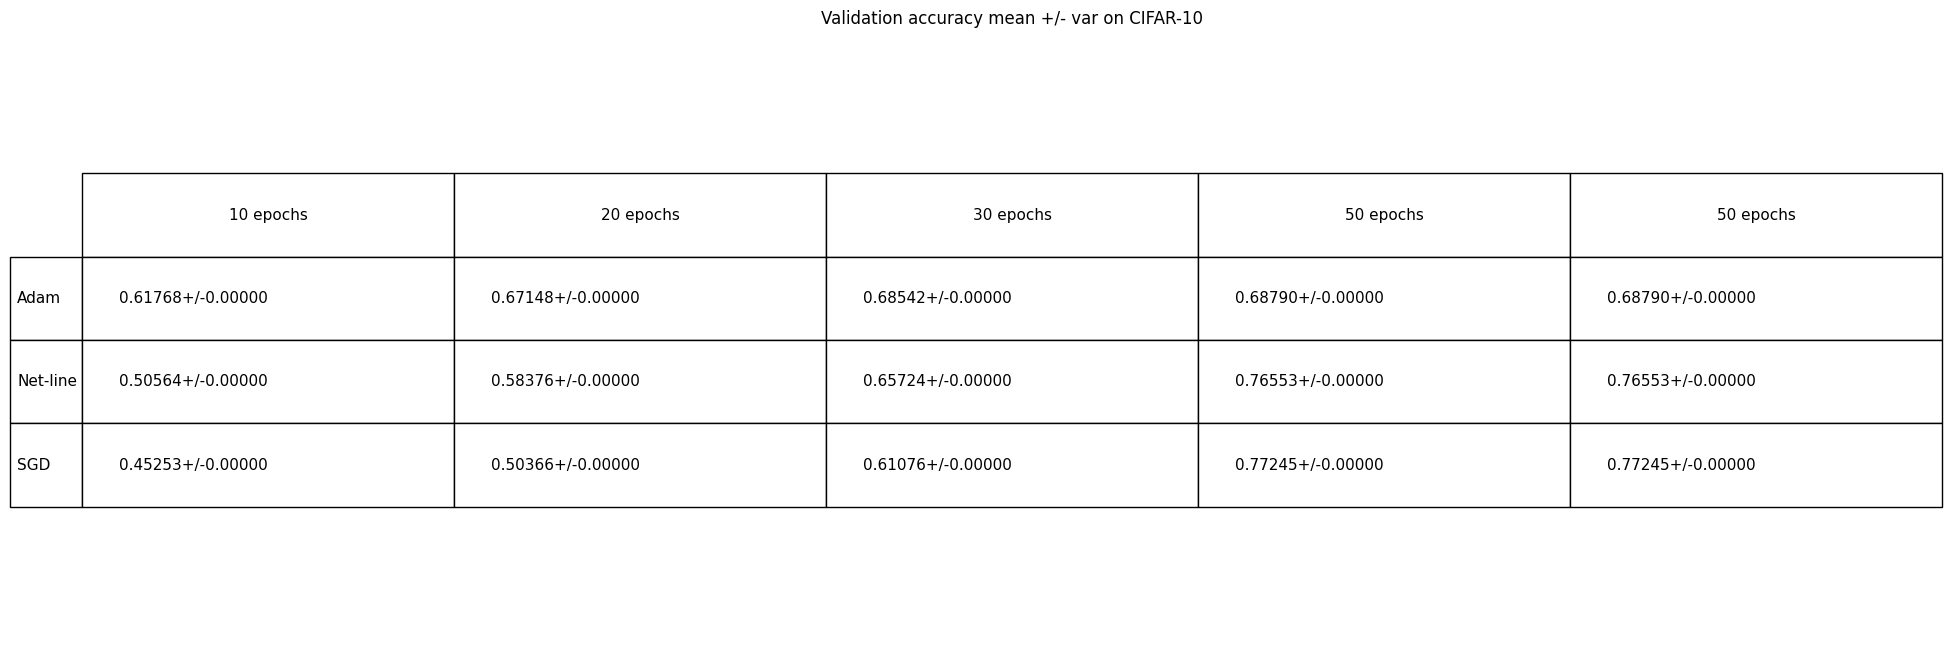

In [23]:
#experimental_results[2, 0:100, 1, 0]
title3 = "Validation accuracy mean +/- var on CIFAR-10"
accuracy_comparison(experimental_results, 0, EPOCHS_PER_EXPERIMENT, title=title3)